In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
#from feature_engine.outliers import Winsorizer

In [2]:
df = pd.read_csv('cdp_data.csv').iloc[:, :12]
df.head(3)

,cdpid,purchasedate,NS,productline,model,purchaseplace,sales_channel,ec_product_name,price_incl_tax,ec_price,qty_ordered,total_price
0,e86bc083-e8bb-4616-838f-4018e624492b,2023/7/25,BQtw,LTV,E55-750,liayo,其他,NaN,NaN,22900,1,22900.0
1,2e0b7637-7905-4b60-be6d-c01d0b564626,2023/6/28,NaN,LTV,E65-730,PC HOME,PC Home,NaN,NaN,21900,1,21900.0
2,1719d059-1aca-416c-8913-ce610a3069ea,2023/6/28,NaN,LCD,EX3210U,benq shopee,Benq Shopee,NaN,NaN,25988,1,25988.0


In [3]:
from datetime import datetime
df['purchasedate'] = pd.to_datetime(df['purchasedate'], format='%Y/%m/%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66550 entries, 0 to 66549
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cdpid            66550 non-null  object        
 1   purchasedate     66550 non-null  datetime64[ns]
 2   NS               4896 non-null   object        
 3   productline      66549 non-null  object        
 4   model            66550 non-null  object        
 5   purchaseplace    54418 non-null  object        
 6   sales_channel    56778 non-null  object        
 7   ec_product_name  6643 non-null   object        
 8   price_incl_tax   6642 non-null   object        
 9   ec_price         66549 non-null  object        
 10  qty_ordered      66550 non-null  object        
 11  total_price      66549 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 6.1+ MB


In [4]:
# Group by 'cdpid' and perform aggregations
result = df.groupby('cdpid').agg(
    frequency=pd.NamedAgg(column='purchasedate', aggfunc='size'),
    recent_purchase=pd.NamedAgg(column='purchasedate', aggfunc='max'),
    monetary=pd.NamedAgg(column='total_price', aggfunc='sum')
).reset_index()

# Calculate recency as the difference between the maximum purchasedate and today's date
result['recency'] = (datetime.now()-result['recent_purchase']).dt.days

# Drop unnecessary column
result =result.drop(['recent_purchase'], axis =1)

In [5]:
result

,cdpid,frequency,monetary,recency
0,0000885e-5fe8-4135-8167-56f2424ab546,1,7990.0,1606
1,00014cfc-dedd-4897-a7d8-57b879a00e2d,1,21900.0,540
2,0001512f-a9dc-429a-a6a1-d4fc47a943ea,1,8988.0,711
3,0006497b-b3eb-4910-baf8-b16c241346d0,1,2888.0,1744
4,0006f4f2-93b2-424f-bb4f-e7babcb24aae,1,3990.0,1845
...,...,...,...,...
55615,fff65171-b570-4079-8e9b-ec36f9631d9a,1,3690.0,1459
55616,fffa295f-1643-4398-9c70-b7f271cdb736,1,14900.0,1596
55617,fffaffd9-c1cd-4271-bda3-ed4f2932c8c1,1,11888.0,1086
55618,fffe1a02-6f3f-49c2-9c86-f5ef183ef3d3,1,29900.0,1478


In [6]:
result.describe()

,frequency,monetary,recency
count,55620.000000,5.562000e+04,55620.000000
mean,1.196512,1.299862e+04,1071.751762
std,1.010971,1.576796e+04,570.921539
min,1.000000,0.000000e+00,190.000000
25%,1.000000,5.788000e+03,594.000000
50%,1.000000,8.990000e+03,973.000000
75%,1.000000,1.557800e+04,1462.000000
max,102.000000,1.748800e+06,2586.000000


(0.0, 500000.0)

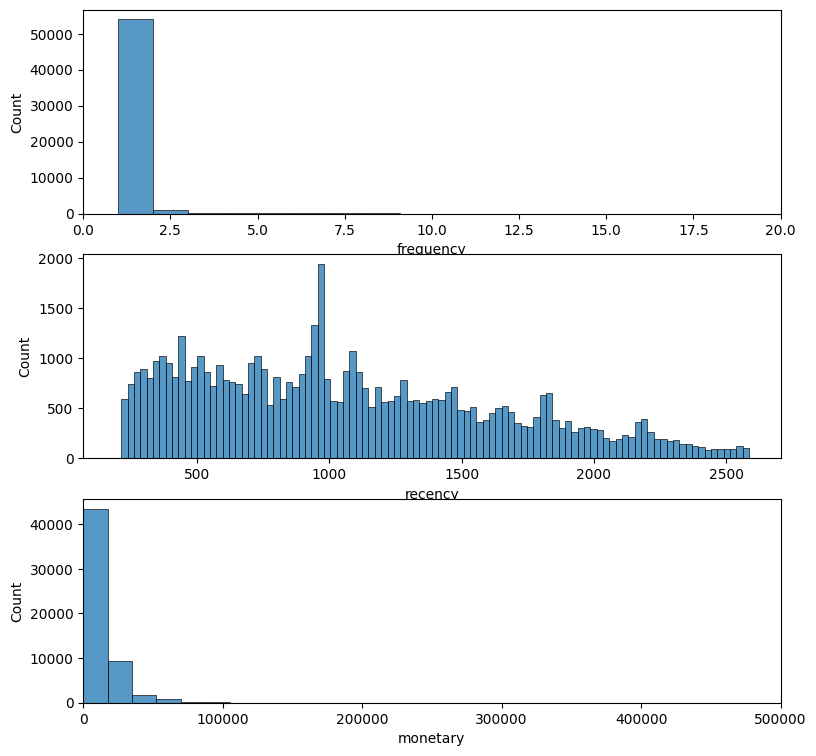

In [7]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
sns.histplot(result['frequency'], bins = 100)
plt.xlim(0, 20)

plt.subplot(3, 1, 2)
sns.histplot(result['recency'], bins = 100)

plt.subplot(3, 1, 3)
sns.histplot(result['monetary'], bins = 100)
plt.xlim(0, 500000)

In [8]:
df_log = result.copy()
df_log.head(3)

,cdpid,frequency,monetary,recency
0,0000885e-5fe8-4135-8167-56f2424ab546,1,7990.0,1606
1,00014cfc-dedd-4897-a7d8-57b879a00e2d,1,21900.0,540
2,0001512f-a9dc-429a-a6a1-d4fc47a943ea,1,8988.0,711


In [9]:
df_log['frequency'] = np.log(df_log['frequency']+1)
df_log['monetary'] = np.log(df_log['monetary']+1)
df_log['recency'] = np.log(df_log['recency']+1)
df_log.head(3)

,cdpid,frequency,monetary,recency
0,0000885e-5fe8-4135-8167-56f2424ab546,0.693147,8.986071,7.382124
1,00014cfc-dedd-4897-a7d8-57b879a00e2d,0.693147,9.994288,6.293419
2,0001512f-a9dc-429a-a6a1-d4fc47a943ea,0.693147,9.103757,6.568078


<Axes: xlabel='recency', ylabel='Count'>

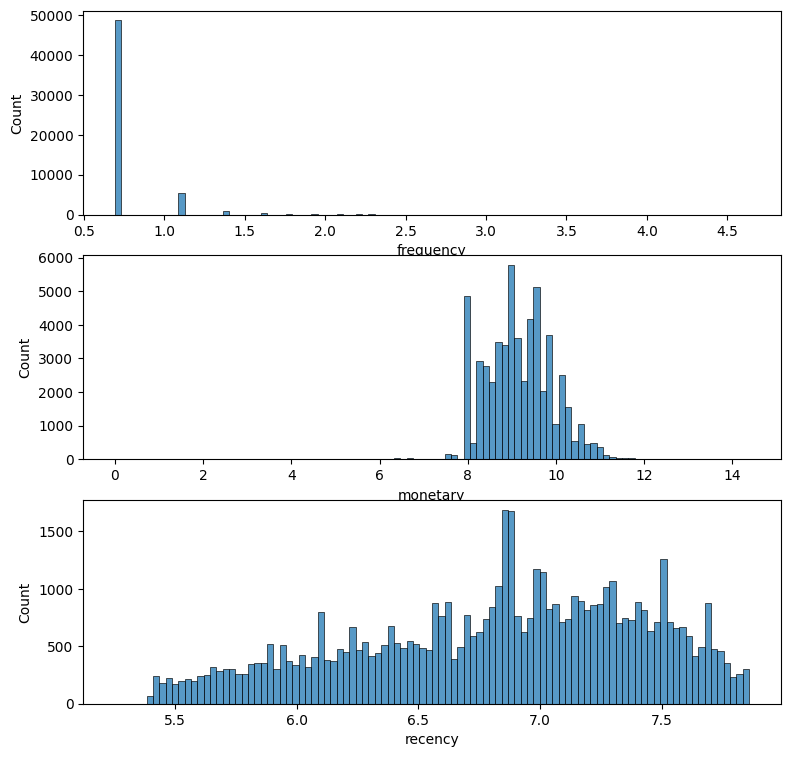

In [10]:
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
sns.histplot(df_log['frequency'], bins = 100)

plt.subplot(3, 1, 2)
sns.histplot(df_log['monetary'], bins = 100)

plt.subplot(3, 1, 3)
sns.histplot(df_log['recency'], bins = 100)

In [11]:
df_log.describe()

,frequency,monetary,recency
count,55620.000000,55620.000000,55620.000000
mean,0.758106,9.163938,6.817008
std,0.197738,0.758005,0.596866
min,0.693147,0.000000,5.252273
25%,0.693147,8.663715,6.388561
50%,0.693147,9.103979,6.881411
75%,0.693147,9.653679,7.288244
max,4.634729,14.374441,7.858254


#windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          #fold=2,
                           #variables=[ 'recency', 'frequency', 'monetary']
                        )
#windsoriser.fit(df_log)

In [12]:
#df_log = windsoriser.transform(df_log)

In [13]:
X = df_log.iloc[:,1:]
scaler = StandardScaler()

scaler.fit(X)

RFM_scaled = scaler.transform(X)

In [14]:
RFM_scaled = pd.DataFrame(RFM_scaled, columns=X.columns)
RFM_scaled.head()

,frequency,monetary,recency
0,-0.328513,-0.234653,0.946816
1,-0.328513,1.095451,-0.877238
2,-0.328513,-0.079394,-0.417065
3,-0.328513,-1.576879,1.084847
4,-0.328513,-1.150584,1.179118


In [15]:
K = range(1,10)
wcss = []

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state = 2024).fit(RFM_scaled) 
    kmeanModel.fit(RFM_scaled)   
    wcss.append(kmeanModel.inertia_)

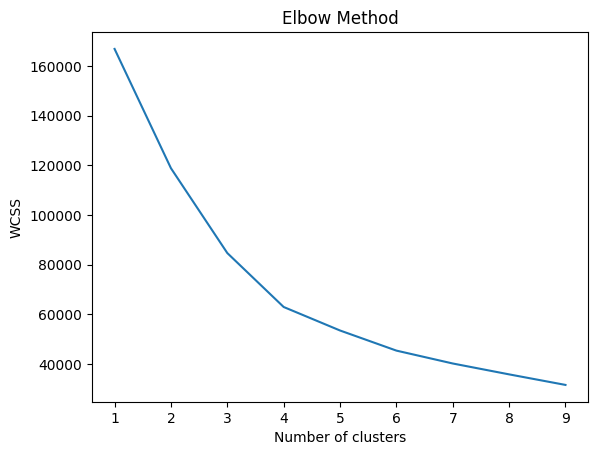

In [16]:
plt.plot(K, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.show()

In [17]:
def create_kmeans(K, standardized_data):
    # Build Kmeans model with certain number of cluster
    Model = KMeans(n_clusters=K, random_state = 2024)

    # Get cluster label and concate on original RFM data
    cluster_labels = Model.fit_predict(standardized_data)
    result_new = result.copy()
    result_new['Cluster']= cluster_labels

    # Plot snake plot
    RFM_scaled_splot = standardized_data.copy()
    RFM_scaled_splot['Cluster'] = cluster_labels

    result_splot = RFM_scaled_splot.groupby('Cluster').agg(
        frequency=pd.NamedAgg(column='frequency', aggfunc='mean'),
        recency=pd.NamedAgg(column='recency', aggfunc='mean'),
        monetary=pd.NamedAgg(column='monetary', aggfunc='mean'))
    
    # Melt the DataFrame for snake plot
    result_splot_melted = pd.melt(result_splot.reset_index(), 
                                id_vars=['Cluster'], 
                                var_name='Metric', 
                                value_name='Mean Value')

    # Create a snake plot using Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Metric', y='Mean Value', hue='Cluster', 
                 data=result_splot_melted, marker="o", ci=None)
    plt.xlabel('Metrics')
    plt.ylabel('Mean Values')
    plt.title('Snake Plot')
    plt.show()

    # Plot RFM table with mean value for each cluster 
    result_new_mean = result_new.iloc[:,1:].groupby('Cluster').agg(
        frequency=pd.NamedAgg(column='frequency', aggfunc='mean'),
        recency=pd.NamedAgg(column='recency', aggfunc='mean'),
        monetary=pd.NamedAgg(column='monetary', aggfunc='mean'))
    
    return result_new_mean

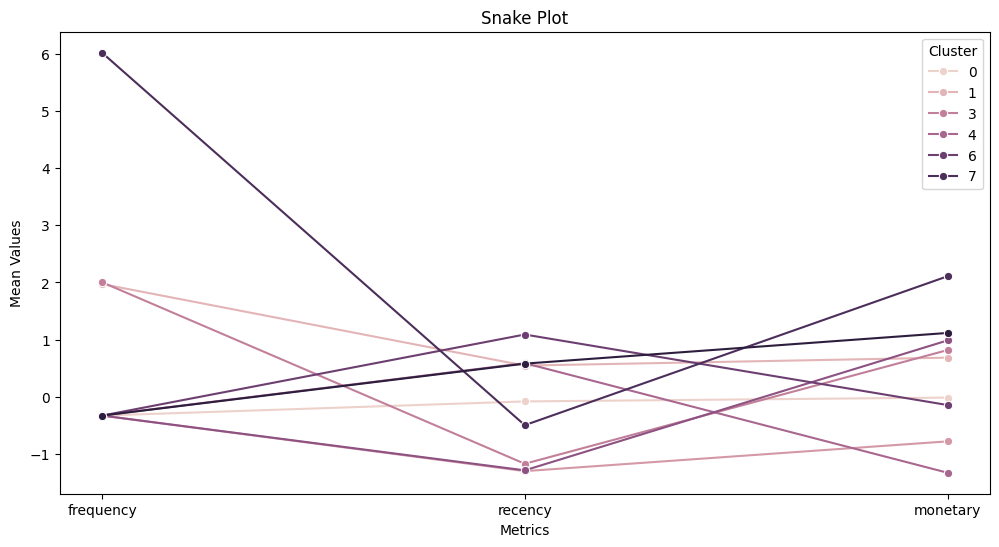

In [18]:
result_new_mean_3 = create_kmeans(K=9, standardized_data=RFM_scaled)

In [19]:
# Take 4 clusters as example

# Build Kmeans model with certain number of cluster
Model = KMeans(n_clusters=4, random_state = 2024)

# Get cluster label and concate on original RFM data
cluster_labels = Model.fit_predict(RFM_scaled)
result_new = result.copy()
result_new['Cluster']= cluster_labels
print(result_new.head(3))

                                  cdpid  frequency  monetary  recency  Cluster
0  0000885e-5fe8-4135-8167-56f2424ab546          1    7990.0     1606        0
1  00014cfc-dedd-4897-a7d8-57b879a00e2d          1   21900.0      540        1
2  0001512f-a9dc-429a-a6a1-d4fc47a943ea          1    8988.0      711        3


In [20]:
'''
# Initiate TSNE
tsne = TSNE(random_state=2023)
result_tsne = tsne.fit_transform(result_new.iloc[:,1:])
print(result_tsne)

# Plot tsne
plt.title('Flattened Graph of {} Clusters'.format(4))
sns.scatterplot(x=result_tsne[:,0], y=result_tsne[:,1], hue=cluster_labels, style=cluster_labels)
'''

"\n# Initiate TSNE\ntsne = TSNE(random_state=2023)\nresult_tsne = tsne.fit_transform(result_new.iloc[:,1:])\nprint(result_tsne)\n\n# Plot tsne\nplt.title('Flattened Graph of {} Clusters'.format(4))\nsns.scatterplot(x=result_tsne[:,0], y=result_tsne[:,1], hue=cluster_labels, style=cluster_labels)\n"

In [21]:
# Plot snake plot
RFM_scaled_splot = RFM_scaled.copy()
RFM_scaled_splot['Cluster'] = cluster_labels

result_splot = RFM_scaled_splot.groupby('Cluster').agg(
    frequency=pd.NamedAgg(column='frequency', aggfunc='mean'),
    recency=pd.NamedAgg(column='recency', aggfunc='mean'),
    monetary=pd.NamedAgg(column='monetary', aggfunc='mean'))


result_splot.head(3)

,frequency,recency,monetary
Cluster,,,
0,-0.320682,0.703830,-0.834659
1,-0.328513,0.341297,0.818063
2,2.321494,-0.148187,0.871022


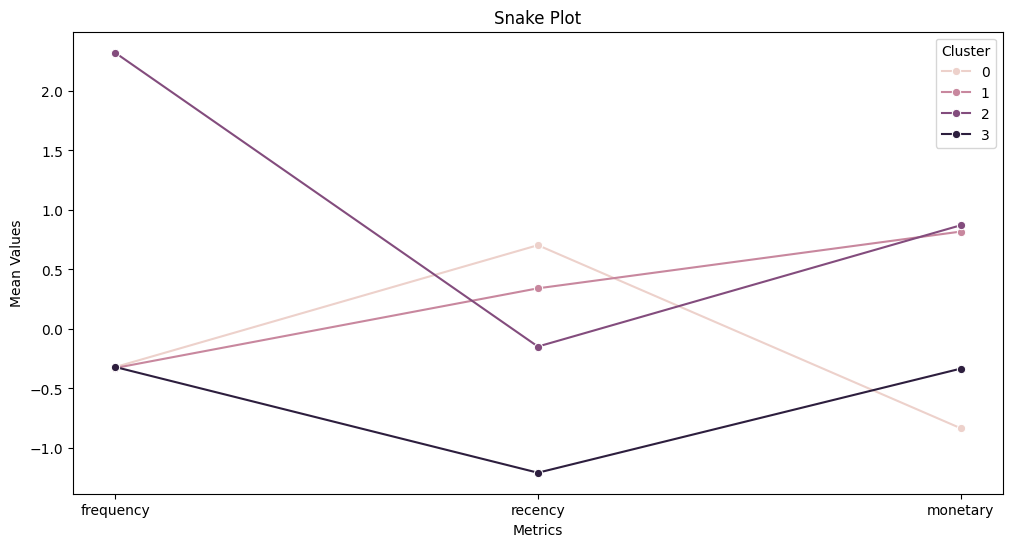

In [22]:

# Set the Seaborn style
#sns.set(style="whitegrid")

# Melt the DataFrame for snake plot
result_splot_melted = pd.melt(result_splot.reset_index(), 
                              id_vars=['Cluster'], 
                              var_name='Metric', 
                              value_name='Mean Value')

# Create a snake plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='Metric', y='Mean Value', hue='Cluster', data=result_splot_melted, marker="o", ci=None)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Mean Values')
plt.title('Snake Plot')

# Show the plot
plt.show()


In [23]:
result_new

,cdpid,frequency,monetary,recency,Cluster
0,0000885e-5fe8-4135-8167-56f2424ab546,1,7990.0,1606,0
1,00014cfc-dedd-4897-a7d8-57b879a00e2d,1,21900.0,540,1
2,0001512f-a9dc-429a-a6a1-d4fc47a943ea,1,8988.0,711,3
3,0006497b-b3eb-4910-baf8-b16c241346d0,1,2888.0,1744,0
4,0006f4f2-93b2-424f-bb4f-e7babcb24aae,1,3990.0,1845,0
...,...,...,...,...,...
55615,fff65171-b570-4079-8e9b-ec36f9631d9a,1,3690.0,1459,0
55616,fffa295f-1643-4398-9c70-b7f271cdb736,1,14900.0,1596,1
55617,fffaffd9-c1cd-4271-bda3-ed4f2932c8c1,1,11888.0,1086,1
55618,fffe1a02-6f3f-49c2-9c86-f5ef183ef3d3,1,29900.0,1478,1


In [24]:
result_new_mean = result_new.iloc[:,1:].groupby('Cluster').agg(
    frequency=pd.NamedAgg(column='frequency', aggfunc='mean'),
    recency=pd.NamedAgg(column='recency', aggfunc='mean'),
    monetary=pd.NamedAgg(column='monetary', aggfunc='mean'),
    count = pd.NamedAgg(column='frequency', aggfunc='size'))


result_new_mean

,frequency,recency,monetary,count
Cluster,,,,
0,1.003819,1468.134625,5525.562482,17805
1,1.000000,1201.772817,19699.074793,16753
2,2.589464,979.500294,24896.258534,6796
3,1.004206,468.296089,8789.240222,14266


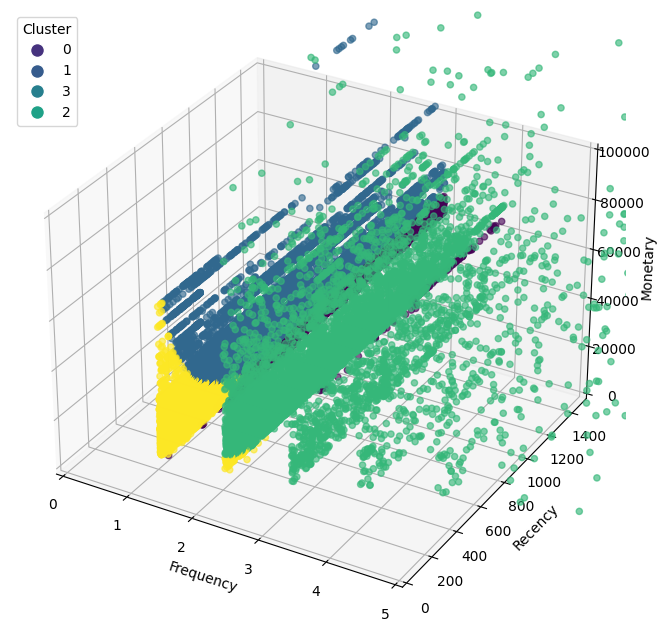

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# 3d plot
plot3d = result_new[['frequency','monetary','recency','Cluster']].copy()

# Create a 3D plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

# Scatter plot with hue
scatter = ax.scatter(plot3d['frequency'], plot3d['recency'], plot3d['monetary'],
                     c = plot3d['Cluster'].astype('category').cat.codes,
                     cmap='viridis')

# Adding labels
ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')

# Set the axis limit
ax.set_xlim(0, 5) #frequency
ax.set_ylim(0, 1500) #recency
ax.set_zlim(-5, 100000) #monetary

# Adding a legend
legend_labels = result_new['Cluster'].unique()
legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=sns.color_palette('viridis')[i],
                          markersize=10) for i, label in enumerate(legend_labels)]
ax.legend(handles=legend_elements, title='Cluster')


# Show the plot
plt.show()

In [29]:
# 3D scatter plot using Plotly
fig = px.scatter_3d(result_new, x='frequency', y='recency', z='monetary', color='Cluster',
                    labels={'frequency': 'Frequency', 'recency': 'Recency', 'monetary': 'Monetary'})

# Set the ranges for all three axes
fig.update_layout(scene=dict(xaxis=dict(range=[0, 10]), #f
                             yaxis=dict(range=[0, 1500]), #r
                             zaxis=dict(range=[-5, 150000]))) #m


# Show the plot
fig.show()